In [24]:
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
import matplotlib.pyplot as plt
import numpy as np

# 1. ADATOK ELŐKÉSZÍTÉSE

In [25]:
file_path = 'NS_adatok_cln.xlsx'
df = pd.read_excel(file_path)
if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)

yield_cols = ['M0.033', 'M1', 'M3', 'M6', 'M12', 'M36', 'M60', 'M120', 'M180']
maturities = [0.033, 1, 3, 6, 12, 36, 60, 120, 180]
maturities_years = np.array([0.033, 1, 3, 6, 12, 36, 60, 120, 180]) / 12
yields_data = df[yield_cols]


gdp_log = np.log(df['GDP'])
cycle, trend = sm.tsa.filters.hpfilter(gdp_log, lamb=1600)
df['Output_Gap'] = cycle * 100

# Egyéb változók
df['Exchange_Rate_Chg'] = np.log(df['Árfolyam']).diff() * 100
df['Base_Rate'] = df['Kamat']
df['Inflation'] = df['Infláció']


# 2. PCA FUTTATÁSA

In [26]:
pca = PCA(n_components=3)
pca.fit(yields_data)

explained_variance = pca.explained_variance_ratio_

print("\n=== PCA EREDMÉNYEK (Magyarázóerő) ===")
print(f"1. Komponens (Level):     {explained_variance[0]*100:.2f}%")
print(f"2. Komponens (Slope):     {explained_variance[1]*100:.2f}%")
print(f"3. Komponens (Curvature): {explained_variance[2]*100:.2f}%")
print("-" * 30)
print(f"Összesített magyarázóerő: {sum(explained_variance)*100:.2f}%")


=== PCA EREDMÉNYEK (Magyarázóerő) ===
1. Komponens (Level):     97.05%
2. Komponens (Slope):     2.65%
3. Komponens (Curvature): 0.22%
------------------------------
Összesített magyarázóerő: 99.92%


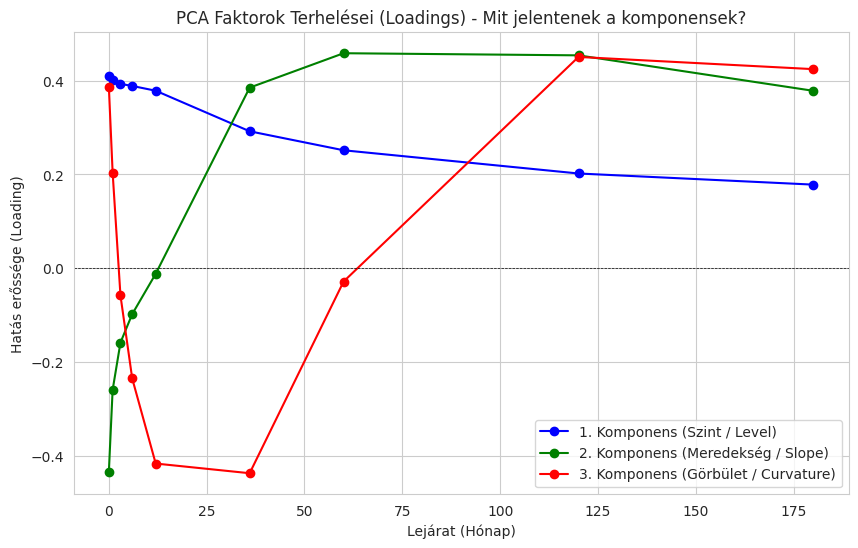

In [27]:
components = pca.components_

plt.figure(figsize=(10, 6))
plt.plot(maturities, components[0], marker='o', label='1. Komponens (Szint / Level)', color='blue')
plt.plot(maturities, components[1], marker='o', label='2. Komponens (Meredekség / Slope)', color='green')
plt.plot(maturities, components[2], marker='o', label='3. Komponens (Görbület / Curvature)', color='red')

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title('PCA Faktorok Terhelései (Loadings) - Mit jelentenek a komponensek?')
plt.xlabel('Lejárat (Hónap)')
plt.ylabel('Hatás erőssége (Loading)')
plt.legend()
plt.grid(True)
plt.show()

# konkrét érték minden időpontra
pca_factors = pca.transform(yields_data)
pca_df = pd.DataFrame(pca_factors, columns=['Level_PCA', 'Slope_PCA', 'Curvature_PCA'], index=df.index)


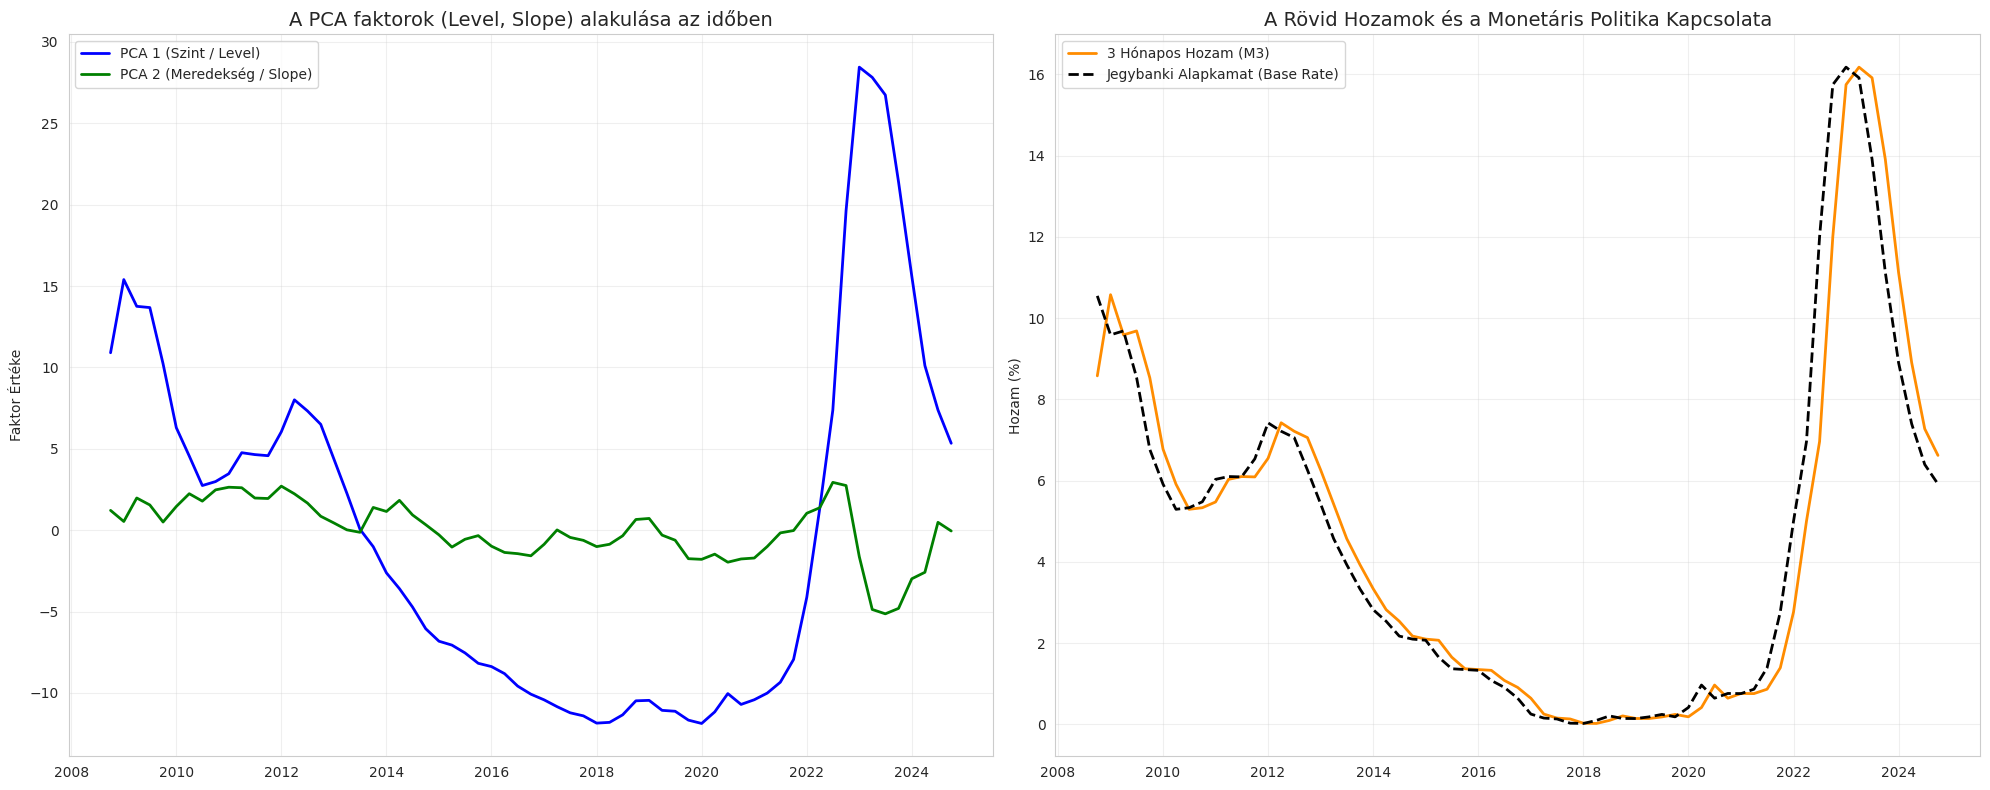

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(pca_df['Level_PCA'], label='PCA 1 (Szint / Level)', color='blue', linewidth=2)
axes[0].plot(pca_df['Slope_PCA'], label='PCA 2 (Meredekség / Slope)', color='green', linewidth=2)

axes[0].set_title('A PCA faktorok (Level, Slope) alakulása az időben', fontsize=14)
axes[0].set_ylabel('Faktor Értéke')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df.index, df['M3'], label='3 Hónapos Hozam (M3)', color='darkorange', linewidth=2)
axes[1].plot(df.index, df['Kamat'], label='Jegybanki Alapkamat (Base Rate)', color='black', linestyle='--', linewidth=2)

axes[1].set_title('A Rövid Hozamok és a Monetáris Politika Kapcsolata', fontsize=14)
axes[1].set_ylabel('Hozam (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# NELSON-SIEGEL FAKTOROK BECSLÉSE

# A Nelson-Siegel Modell Matematikai Levezetése és Becslése

Ebben a részben a hozamgörbe ($y_t(\tau)$) felbontását végeztük el látens (nem megfigyelhető) faktorokra a **Nelson-Siegel (1987)** keretrendszer segítségével.

## 1. A Nelson-Siegel Egyenlet

A modell alapfeltevése, hogy a $t$ időpontban a $\tau$ lejárathoz tartozó azonnali (spot) hozam három komponens lineáris kombinációjaként áll elő:

$$
y_t(\tau) = L_t + S_t \left( \frac{1 - e^{-\lambda \tau}}{\lambda \tau} \right) + C_t \left( \frac{1 - e^{-\lambda \tau}}{\lambda \tau} - e^{-\lambda \tau} \right) + \varepsilon_t(\tau)
$$

Ahol:
* $y_t(\tau)$: A megfigyelt hozam a $t$ időpontban $\tau$ lejárra.
* $\lambda$: A lecsengési paraméter (decay parameter), amely a görbület helyét határozza meg.
* **A látens faktorok:**
    * $L_t$ (**Level**): Hosszú távú kamatszint (a hozamgörbe szintje).
    * $S_t$ (**Slope**): A hozamgörbe meredeksége (rövid távú - hosszú távú hozam).
    * $C_t$ (**Curvature**): A hozamgörbe görbülete (púpja).

### Gazdasági Interpretáció (Határértékek)
A matematikai határértékek igazolják a faktorok elnevezését:
* **Level:** $\lim_{\tau \to \infty} y_t(\tau) = L_t$ (mivel a többi tag 0-hoz tart).
* **Slope:** $\lim_{\tau \to 0} y_t(\tau) = L_t + S_t$. Tehát a rövid hozam $L+S$, a hosszú hozam $L$, a különbségük (meredekség) pedig $-S_t$.

## 2. A Becslési Eljárás (Kétlépcsős Módszer)

Mivel a $\lambda$ paraméter nem-lineárisan szerepel az egyenletben, a becslést nem tudjuk egyetlen egyszerű lineáris regresszióval elvégezni. Ezért a **Diebold-Li (2006)** féle kétlépcsős eljárást (vagy annak iteratív optimalizálását) alkalmaztuk.

### A) A Regresszorok (Loadings) Előállítása
Rögzített $\lambda$ mellett a faktorokhoz tartozó súlyfüggvények (loadings) konstansokká válnak minden $t$ időpontban. Jelölje $X$ a magyarázó változók mátrixát (Design Matrix):

Legyenek a lejáratok: $\tau_1, \tau_2, \dots, \tau_N$. Ekkor az $X$ mátrix:

$$
X = \begin{bmatrix}
1 & \frac{1 - e^{-\lambda \tau_1}}{\lambda \tau_1} & \frac{1 - e^{-\lambda \tau_1}}{\lambda \tau_1} - e^{-\lambda \tau_1} \\
1 & \frac{1 - e^{-\lambda \tau_2}}{\lambda \tau_2} & \frac{1 - e^{-\lambda \tau_2}}{\lambda \tau_2} - e^{-\lambda \tau_2} \\
\vdots & \vdots & \vdots \\
1 & \frac{1 - e^{-\lambda \tau_N}}{\lambda \tau_N} & \frac{1 - e^{-\lambda \tau_N}}{\lambda \tau_N} - e^{-\lambda \tau_N}
\end{bmatrix}
$$

### B) Lineáris Regresszió (OLS) minden időpontra
Minden egyes $t$ időpontban rendelkezésre áll a hozamok vektora $Y_t = [y_t(\tau_1), \dots, y_t(\tau_N)]^T$.
A keresett faktorok vektora: $\beta_t = [L_t, S_t, C_t]^T$.

A becsülendő egyenlet mátrix formában:
$$
Y_t = X \beta_t + \varepsilon_t
$$

Mivel $X$ ismert (fix $\lambda$ mellett), a faktorok becslése a **Legkisebb Négyzetek Módszerével (OLS)** történik:

$$
\hat{\beta}_t = (X^T X)^{-1} X^T Y_t
$$

Ezt a lépést a Python kódunk a `LinearRegression` függvénnyel végezte el minden egyes dátumra.

### C) A Lambda ($\lambda$) Optimalizálása
Hogy megtaláljuk a legjobb $\lambda$ értéket, egy nem-lineáris optimalizálást (Nelder-Mead algoritmus) futtattunk. A célfüggvény a teljes modell átlagos négyzetes hibájának (RMSE) minimalizálása volt az összes időpontra ($T$) és lejáratra ($N$) nézve:

$$
\min_{\lambda} \sqrt{ \frac{1}{T \cdot N} \sum_{t=1}^{T} \sum_{i=1}^{N} \left( y_t(\tau_i) - \hat{y}_t(\tau_i | \lambda) \right)^2 }
$$

Ahol $\hat{y}_t(\tau_i | \lambda)$ a modell által visszabecsült hozam az adott $\lambda$-val számolt faktorok alapján.

**Eredmény:**
* A 3-faktoros modellhez kapott optimális érték: **$\lambda \approx 0.6056$**
* A Reppa-féle 2-faktoros (C=0) modellhez: **$\lambda \approx 0.5502$**

Lambda optimalizálása...
-> 2-faktoros Lambda: 0.5502
-> 3-faktoros Lambda: 0.6056


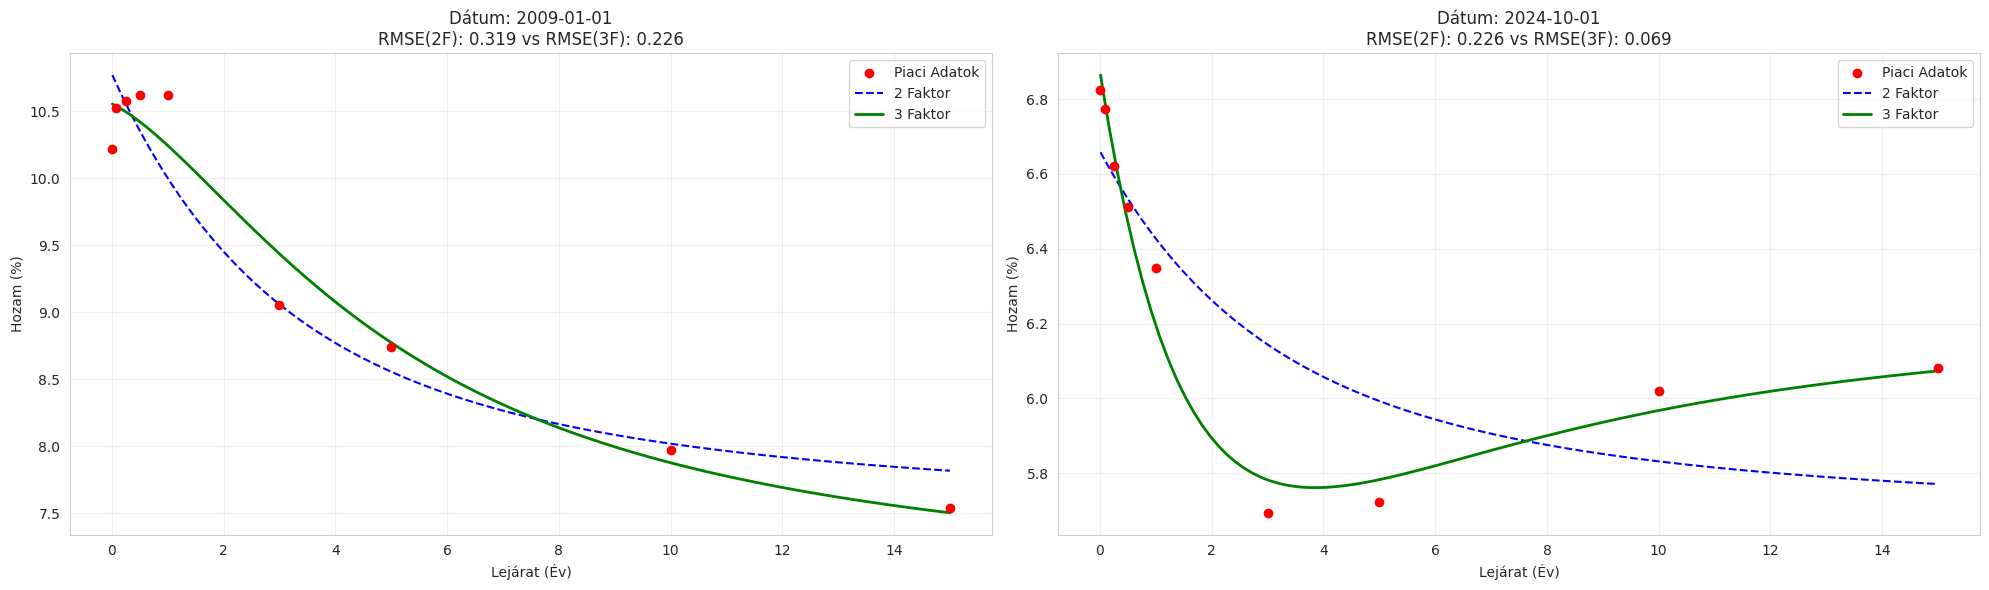

In [29]:
date1 = '2009-01-01'
date2 = '2024-10-01'

def ns_loadings_2factor(tau, lam):
    col_level = np.ones_like(tau)
    col_slope = (1 - np.exp(-lam * tau)) / (lam * tau)
    return np.column_stack((col_level, col_slope))

def ns_loadings_3factor(tau, lam):
    col_level = np.ones_like(tau)
    col_slope = (1 - np.exp(-lam * tau)) / (lam * tau)
    col_curv = col_slope - np.exp(-lam * tau)
    return np.column_stack((col_level, col_slope, col_curv))

def get_rmse_generic(lam, y_data, tau, model_func):
    if lam <= 0: return 1e10
    X = model_func(tau, lam)
    try:
        beta = np.linalg.pinv(X) @ y_data.values.T
        y_pred = (X @ beta).T
        return np.sqrt(np.mean((y_data.values - y_pred)**2))
    except:
        return 1e10

print("Lambda optimalizálása...")
res_2f = minimize(get_rmse_generic, x0=0.7, args=(yields_data, maturities_years, ns_loadings_2factor), method='Nelder-Mead')
opt_lambda_2f = res_2f.x[0]
res_3f = minimize(get_rmse_generic, x0=0.7, args=(yields_data, maturities_years, ns_loadings_3factor), method='Nelder-Mead')
opt_lambda_3f = res_3f.x[0]

print(f"-> 2-faktoros Lambda: {opt_lambda_2f:.4f}")
print(f"-> 3-faktoros Lambda: {opt_lambda_3f:.4f}")

def plot_ns_fit(ax, date, y_data_all, tau, lam2, lam3):
    if date not in y_data_all.index:
        date = y_data_all.index[0]

    actuals = y_data_all.loc[date].values

    # 2 Faktoros Illesztés
    X2 = ns_loadings_2factor(tau, lam2)
    reg2 = LinearRegression(fit_intercept=False).fit(X2, actuals)

    # 3 Faktoros Illesztés
    X3 = ns_loadings_3factor(tau, lam3)
    reg3 = LinearRegression(fit_intercept=False).fit(X3, actuals)

    # Görbék generálása
    tau_smooth = np.linspace(0.01, 15, 100)
    curve2 = reg2.predict(ns_loadings_2factor(tau_smooth, lam2))
    curve3 = reg3.predict(ns_loadings_3factor(tau_smooth, lam3))

    # Plotolás
    ax.scatter(tau, actuals, color='red', label='Piaci Adatok', zorder=5)
    ax.plot(tau_smooth, curve2, label=f'2 Faktor', color='blue', linestyle='--')
    ax.plot(tau_smooth, curve3, label=f'3 Faktor', color='green', linewidth=2)

    rmse2 = np.sqrt(np.mean((actuals - reg2.predict(X2))**2))
    rmse3 = np.sqrt(np.mean((actuals - reg3.predict(X3))**2))

    ax.set_title(f'Dátum: {str(date)[:10]}\nRMSE(2F): {rmse2:.3f} vs RMSE(3F): {rmse3:.3f}')
    ax.set_xlabel('Lejárat (Év)')
    ax.set_ylabel('Hozam (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plot_ns_fit(axes[0], date1, yields_data, maturities_years, opt_lambda_2f, opt_lambda_3f)
plot_ns_fit(axes[1], date2, yields_data, maturities_years, opt_lambda_2f, opt_lambda_3f)

plt.tight_layout()
#plt.savefig('ns_comparison_2dates.png')
plt.show()


## STACIONARITÁS VIZSGÁLAT (ADF TESZT)

In [30]:
X_3f = ns_loadings_3factor(maturities_years, opt_lambda_3f)
ns_factors_3f = []

for index, row in yields_data.iterrows():
    reg = LinearRegression(fit_intercept=False).fit(X_3f, row.values)
    ns_factors_3f.append(reg.coef_)

ns_df_3f = pd.DataFrame(ns_factors_3f, columns=['Level_NS', 'Slope_NS', 'Curvature_NS'], index=df.index)
var_data_3f = pd.concat([
    ns_df_3f[['Level_NS', 'Slope_NS', 'Curvature_NS']],
    df[['Base_Rate', 'Inflation', 'Output_Gap', 'Exchange_Rate_Chg']]
], axis=1).dropna()

print("\n=== Stacionaritás Vizsgálat (ADF) a 3-Faktoros Modellel ===")
print(f"{'Változó':<20} {'ADF Stat':<10} {'p-érték':<10} {'Eredmény'}")
print("-" * 55)

for col in var_data_3f.columns:
    result = adfuller(var_data_3f[col])
    p_value = result[1]
    if p_value < 0.05:
        verdict = "Stacioner (OK)"
    else:
        verdict = "Nem stacioner (!)"
    print(f"{col:<20} {result[0]:<10.4f} {p_value:<10.4f} {verdict}")


=== Stacionaritás Vizsgálat (ADF) a 3-Faktoros Modellel ===
Változó              ADF Stat   p-érték    Eredmény
-------------------------------------------------------
Level_NS             -1.9703    0.2998     Nem stacioner (!)
Slope_NS             -1.3004    0.6290     Nem stacioner (!)
Curvature_NS         -3.0048    0.0344     Stacioner (OK)
Base_Rate            -1.2654    0.6449     Nem stacioner (!)
Inflation            -0.6489    0.8595     Nem stacioner (!)
Output_Gap           -5.1021    0.0000     Stacioner (OK)
Exchange_Rate_Chg    -6.6604    0.0000     Stacioner (OK)


# VAR model

In [31]:
USE_3_FACTOR_MODEL = False  # True: 3 Faktor (L, S, C), False: 2 Faktor (L, S)

--- MODELL: 2 FAKTOROS (Kálmán-szűrővel) ---
Kezdőértékek számítása OLS-sel (hogy stabil legyen a Kálmán)...
Kálmán-szűrő futtatása...
-> Kálmán-szűrő sikeres! Faktorok kiszámolva.


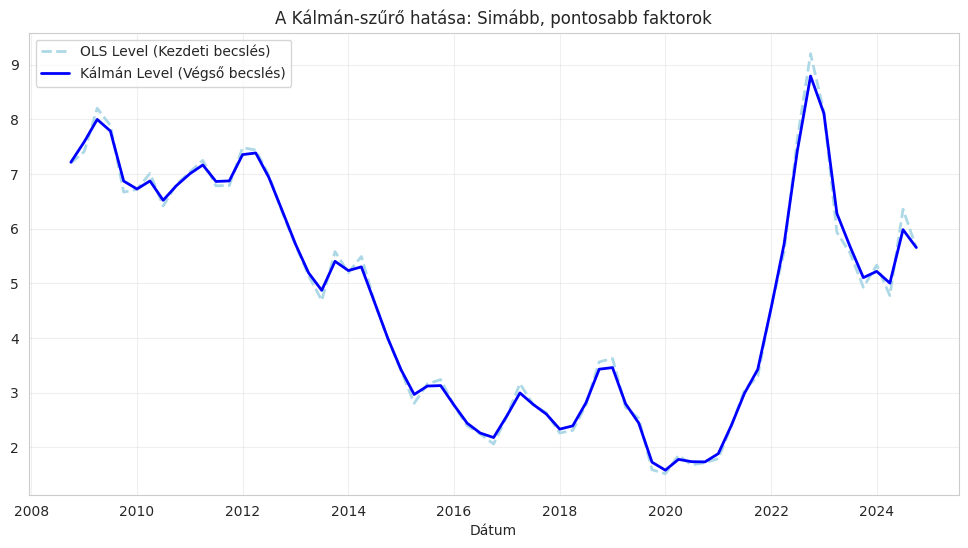

VAR modell építése a Kálmán-faktorokkal...
-> SIKER: A modell stabil!


<Figure size 1200x1000 with 0 Axes>

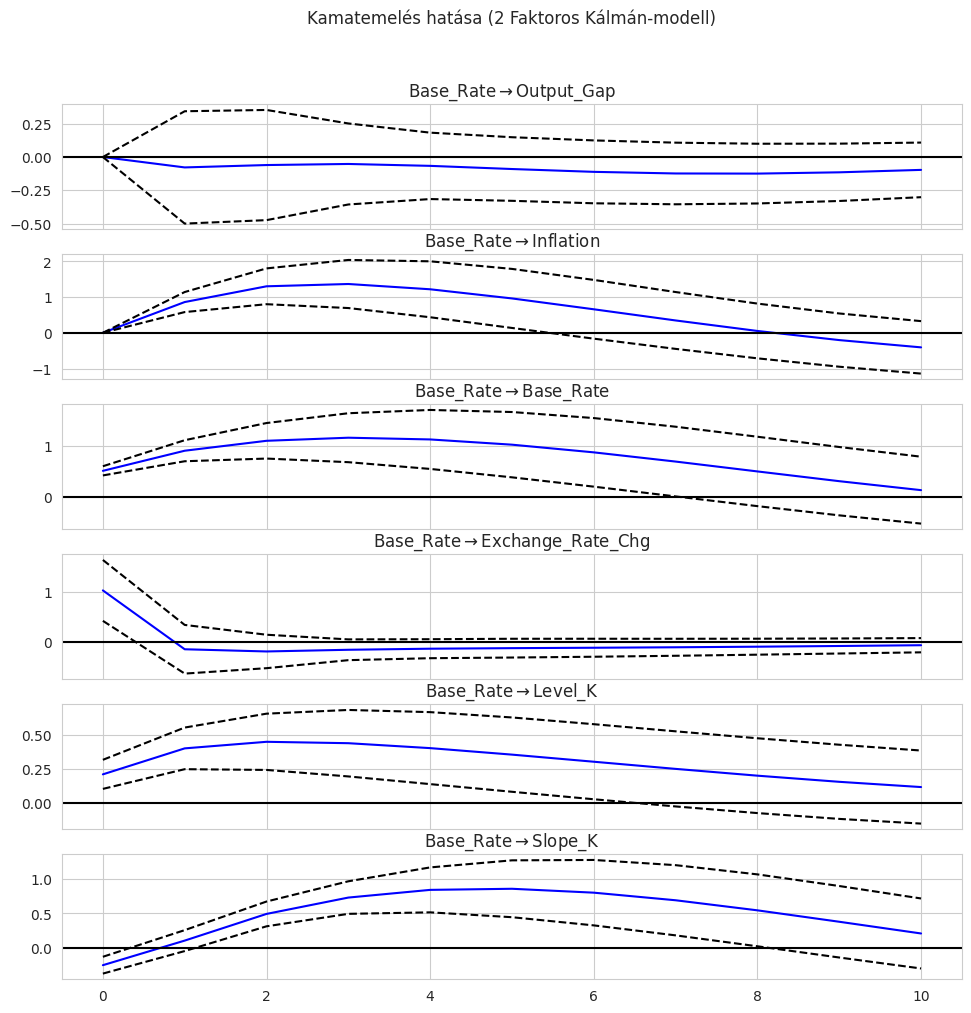


=== Szórásfelbontás: Mi mozgatja a Level_K faktort? ===
FEVD for Output_Gap
     Output_Gap  Inflation  Base_Rate  Exchange_Rate_Chg   Level_K   Slope_K
0      1.000000   0.000000   0.000000           0.000000  0.000000  0.000000
1      0.993456   0.001378   0.001079           0.000000  0.004087  0.000000
2      0.986811   0.002235   0.001686           0.000037  0.009230  0.000001
3      0.982013   0.002319   0.002144           0.000115  0.013407  0.000001
4      0.978274   0.002420   0.002891           0.000141  0.016271  0.000002
5      0.974424   0.003156   0.004266           0.000146  0.017998  0.000009
6      0.969813   0.004685   0.006351           0.000256  0.018869  0.000027
7      0.964536   0.006800   0.008888           0.000549  0.019171  0.000055
8      0.959180   0.009123   0.011431           0.001008  0.019168  0.000089
9      0.954434   0.011275   0.013561           0.001546  0.019061  0.000124

FEVD for Inflation
     Output_Gap  Inflation  Base_Rate  Exchange_Rate_Chg

In [32]:
print(f"--- MODELL: {'3 FAKTOROS (Kálmán-szűrővel)' if USE_3_FACTOR_MODEL else '2 FAKTOROS (Kálmán-szűrővel)'} ---")

# =============================================================================
# 3. KÁLMÁN-SZŰRŐ (STATE-SPACE) MODELL DEFINIÁLÁSA - JAVÍTOTT
# =============================================================================
if USE_3_FACTOR_MODEL:
    opt_lambda = 0.6056
    n_factors = 3
    factor_names = ['Level_K', 'Slope_K', 'Curvature_K']
else:
    opt_lambda = 0.5502
    n_factors = 2
    factor_names = ['Level_K', 'Slope_K']

def get_design_matrix(tau, lam, n_fact):
    col_level = np.ones_like(tau)
    col_slope = (1 - np.exp(-lam * tau)) / (lam * tau)
    if n_fact == 3:
        col_curv = col_slope - np.exp(-lam * tau)
        return np.column_stack((col_level, col_slope, col_curv))
    else:
        return np.column_stack((col_level, col_slope))

class NelsonSiegelSSM(MLEModel):
    def __init__(self, endog, maturities, lam, n_fact):
        super().__init__(endog, k_states=n_fact, k_posdef=n_fact, initialization='approximate_diffuse')
        self.maturities = maturities
        self.lam = lam
        self.n_fact = n_fact

        # Design matrix (H) - Fix, nem becsüljük
        design = get_design_matrix(maturities, lam, n_fact)

        # JAVÍTÁS: Töröltük a .T -t!
        # A mátrixnak (9 sor, 3 oszlop) alakúnak kell lennie.
        self['design'] = design

        # Selection matrix (R) - Egységmátrix
        self['selection'] = np.eye(n_fact)

    def update(self, params, **kwargs):
        params = super().update(params, **kwargs)

        # Transition Matrix (F) - VAR(1) a faktorokra
        # n_fact * n_fact paraméter
        idx = 0
        transition = np.array(params[idx : idx + self.n_fact**2]).reshape(self.n_fact, self.n_fact)
        self['transition'] = transition
        idx += self.n_fact**2

        # State Covariance (Q) - Faktorok zajszintje
        state_cov_diag = params[idx : idx + self.n_fact]
        self['state_cov'] = np.diag(state_cov_diag**2)
        idx += self.n_fact

        # Observation Covariance (R) - Mérési hiba
        obs_cov_val = params[idx]
        self['obs_cov'] = np.eye(len(self.maturities)) * obs_cov_val**2
# =============================================================================
# 4. BECSLÉS (KÉT LÉPCSŐBEN: OLS "TIPP" -> KÁLMÁN "FINOMÍTÁS") - JAVÍTOTT
# =============================================================================
print("Kezdőértékek számítása OLS-sel (hogy stabil legyen a Kálmán)...")

# A) OLS futtatása a kezdőértékekhez
X_ols = get_design_matrix(maturities_years, opt_lambda, n_factors)
factors_ols = []
for _, row in yields_data.iterrows():
    reg = LinearRegression(fit_intercept=False).fit(X_ols, row.values)
    factors_ols.append(reg.coef_)

# JAVÍTÁS: Hozzáadtuk az indexet és az oszlopneveket!
df_ols = pd.DataFrame(factors_ols, columns=factor_names, index=df.index)

# B) VAR(1) az OLS faktorokon -> Transition Matrix tipp
var_ols = VAR(df_ols)
res_ols = var_ols.fit(1)
trans_guess = res_ols.coefs[0].flatten()
cov_guess = np.sqrt(np.diag(res_ols.sigma_u))
obs_err_guess = [0.1] # Kezdő tipp a mérési hibára

# C) Kálmán-szűrő indítása a tippekkel
start_params = np.concatenate([trans_guess, cov_guess, obs_err_guess])

print("Kálmán-szűrő futtatása...")
mod_kf = NelsonSiegelSSM(yields_data, maturities_years, opt_lambda, n_factors)
# A 'bfgs' optimalizáló robusztusabb itt
res_kf = mod_kf.fit(start_params=start_params, method='bfgs', maxiter=1000, disp=False)

# Faktorok kinyerése (Smoothed states)
kf_factors_df = pd.DataFrame(res_kf.smoothed_state.T, columns=factor_names, index=df.index)

print("-> Kálmán-szűrő sikeres! Faktorok kiszámolva.")

# Ábrázolás: OLS vs Kálmán (Most már jónak kell lennie!)
plt.figure(figsize=(12, 6))
# Most már mindkettőnek van dátum indexe, így jó helyre kerülnek
col_to_plot = 'Level_K' # Vagy Level_NS, attól függően mi a neve a listában
plt.plot(df_ols[col_to_plot], label='OLS Level (Kezdeti becslés)', color='lightblue', linestyle='--', linewidth=2)
plt.plot(kf_factors_df[col_to_plot], label='Kálmán Level (Végső becslés)', color='blue', linewidth=2)

plt.title('A Kálmán-szűrő hatása: Simább, pontosabb faktorok')
plt.xlabel('Dátum')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# 5. VÉGSŐ VAR MODELL (MOST MÁR A KÁLMÁN FAKTOROKKAL)
# =============================================================================
print("VAR modell építése a Kálmán-faktorokkal...")

# Makrováltozók (Újra definiáljuk a biztonság kedvéért)
gdp_log = np.log(df['GDP'])
cycle, _ = sm.tsa.filters.hpfilter(gdp_log, lamb=1600)
df['Output_Gap'] = cycle * 100
df['Exchange_Rate_Chg'] = np.log(df['Árfolyam']).diff() * 100
df['Base_Rate'] = df['Kamat']
df['Inflation'] = df['Infláció']

# Adatok összeállítása
# Fontos: A kf_factors_df-et használjuk!
var_data = pd.concat([df[['Output_Gap', 'Inflation', 'Base_Rate', 'Exchange_Rate_Chg']], kf_factors_df], axis=1).dropna()

# Modell futtatása
model = VAR(var_data)
results = model.fit(1)

if results.is_stable():
    print("-> SIKER: A modell stabil!")

    # Impulzus-válaszok
    irf = results.irf(10)
    plt.figure(figsize=(12, 10))
    irf.plot(orth=True, impulse='Base_Rate')
    plt.suptitle(f'Kamatemelés hatása ({n_factors} Faktoros Kálmán-modell)', y=1.02)
    plt.show()

    print(f"\n=== Szórásfelbontás: Mi mozgatja a {col_to_plot} faktort? ===")

    fevd = results.fevd(10)

    # 1. Kiíratjuk a teljes táblázatot (ez a legbiztosabb)
    fevd.summary()

    # 2. Programozott lekérdezés (Javított indexeléssel)
    try:
        # Megkeressük az indexeket
        target_idx = list(var_data.columns).index(col_to_plot) # Level_K indexe
        shock_idx = list(var_data.columns).index('Base_Rate')  # Kamat indexe

        # Mátrix alakjának ellenőrzése és helyes indexelés
        decomp_shape = fevd.decomp.shape
        # print(f"DEBUG: Mátrix alakja: {decomp_shape}")

        if decomp_shape[0] == 10:
            # Ha (Idő, Változó, Sokk) a sorrend (Standard)
            impact = fevd.decomp[9, target_idx, shock_idx] * 100
        else:
            # Ha (Változó, Változó, Idő) a sorrend (A te eseted)
            impact = fevd.decomp[target_idx, shock_idx, 9] * 100

        print(f"\nEredmény: A Kamat (Base_Rate) a 10. negyedévben {impact:.2f}%-ban magyarázza a {col_to_plot} mozgását.")

    except Exception as e:
        print(f"\nNem sikerült a számot automatikusan kinyerni (Hiba: {e}), de a fenti táblázatban látható az érték!")

else:
    print("HIBA: A modell instabil. Próbáld meg a másik faktorszámot (USE_3_FACTOR_MODEL = False).")

Impulzus-válaszok számítása és ábrázolása...


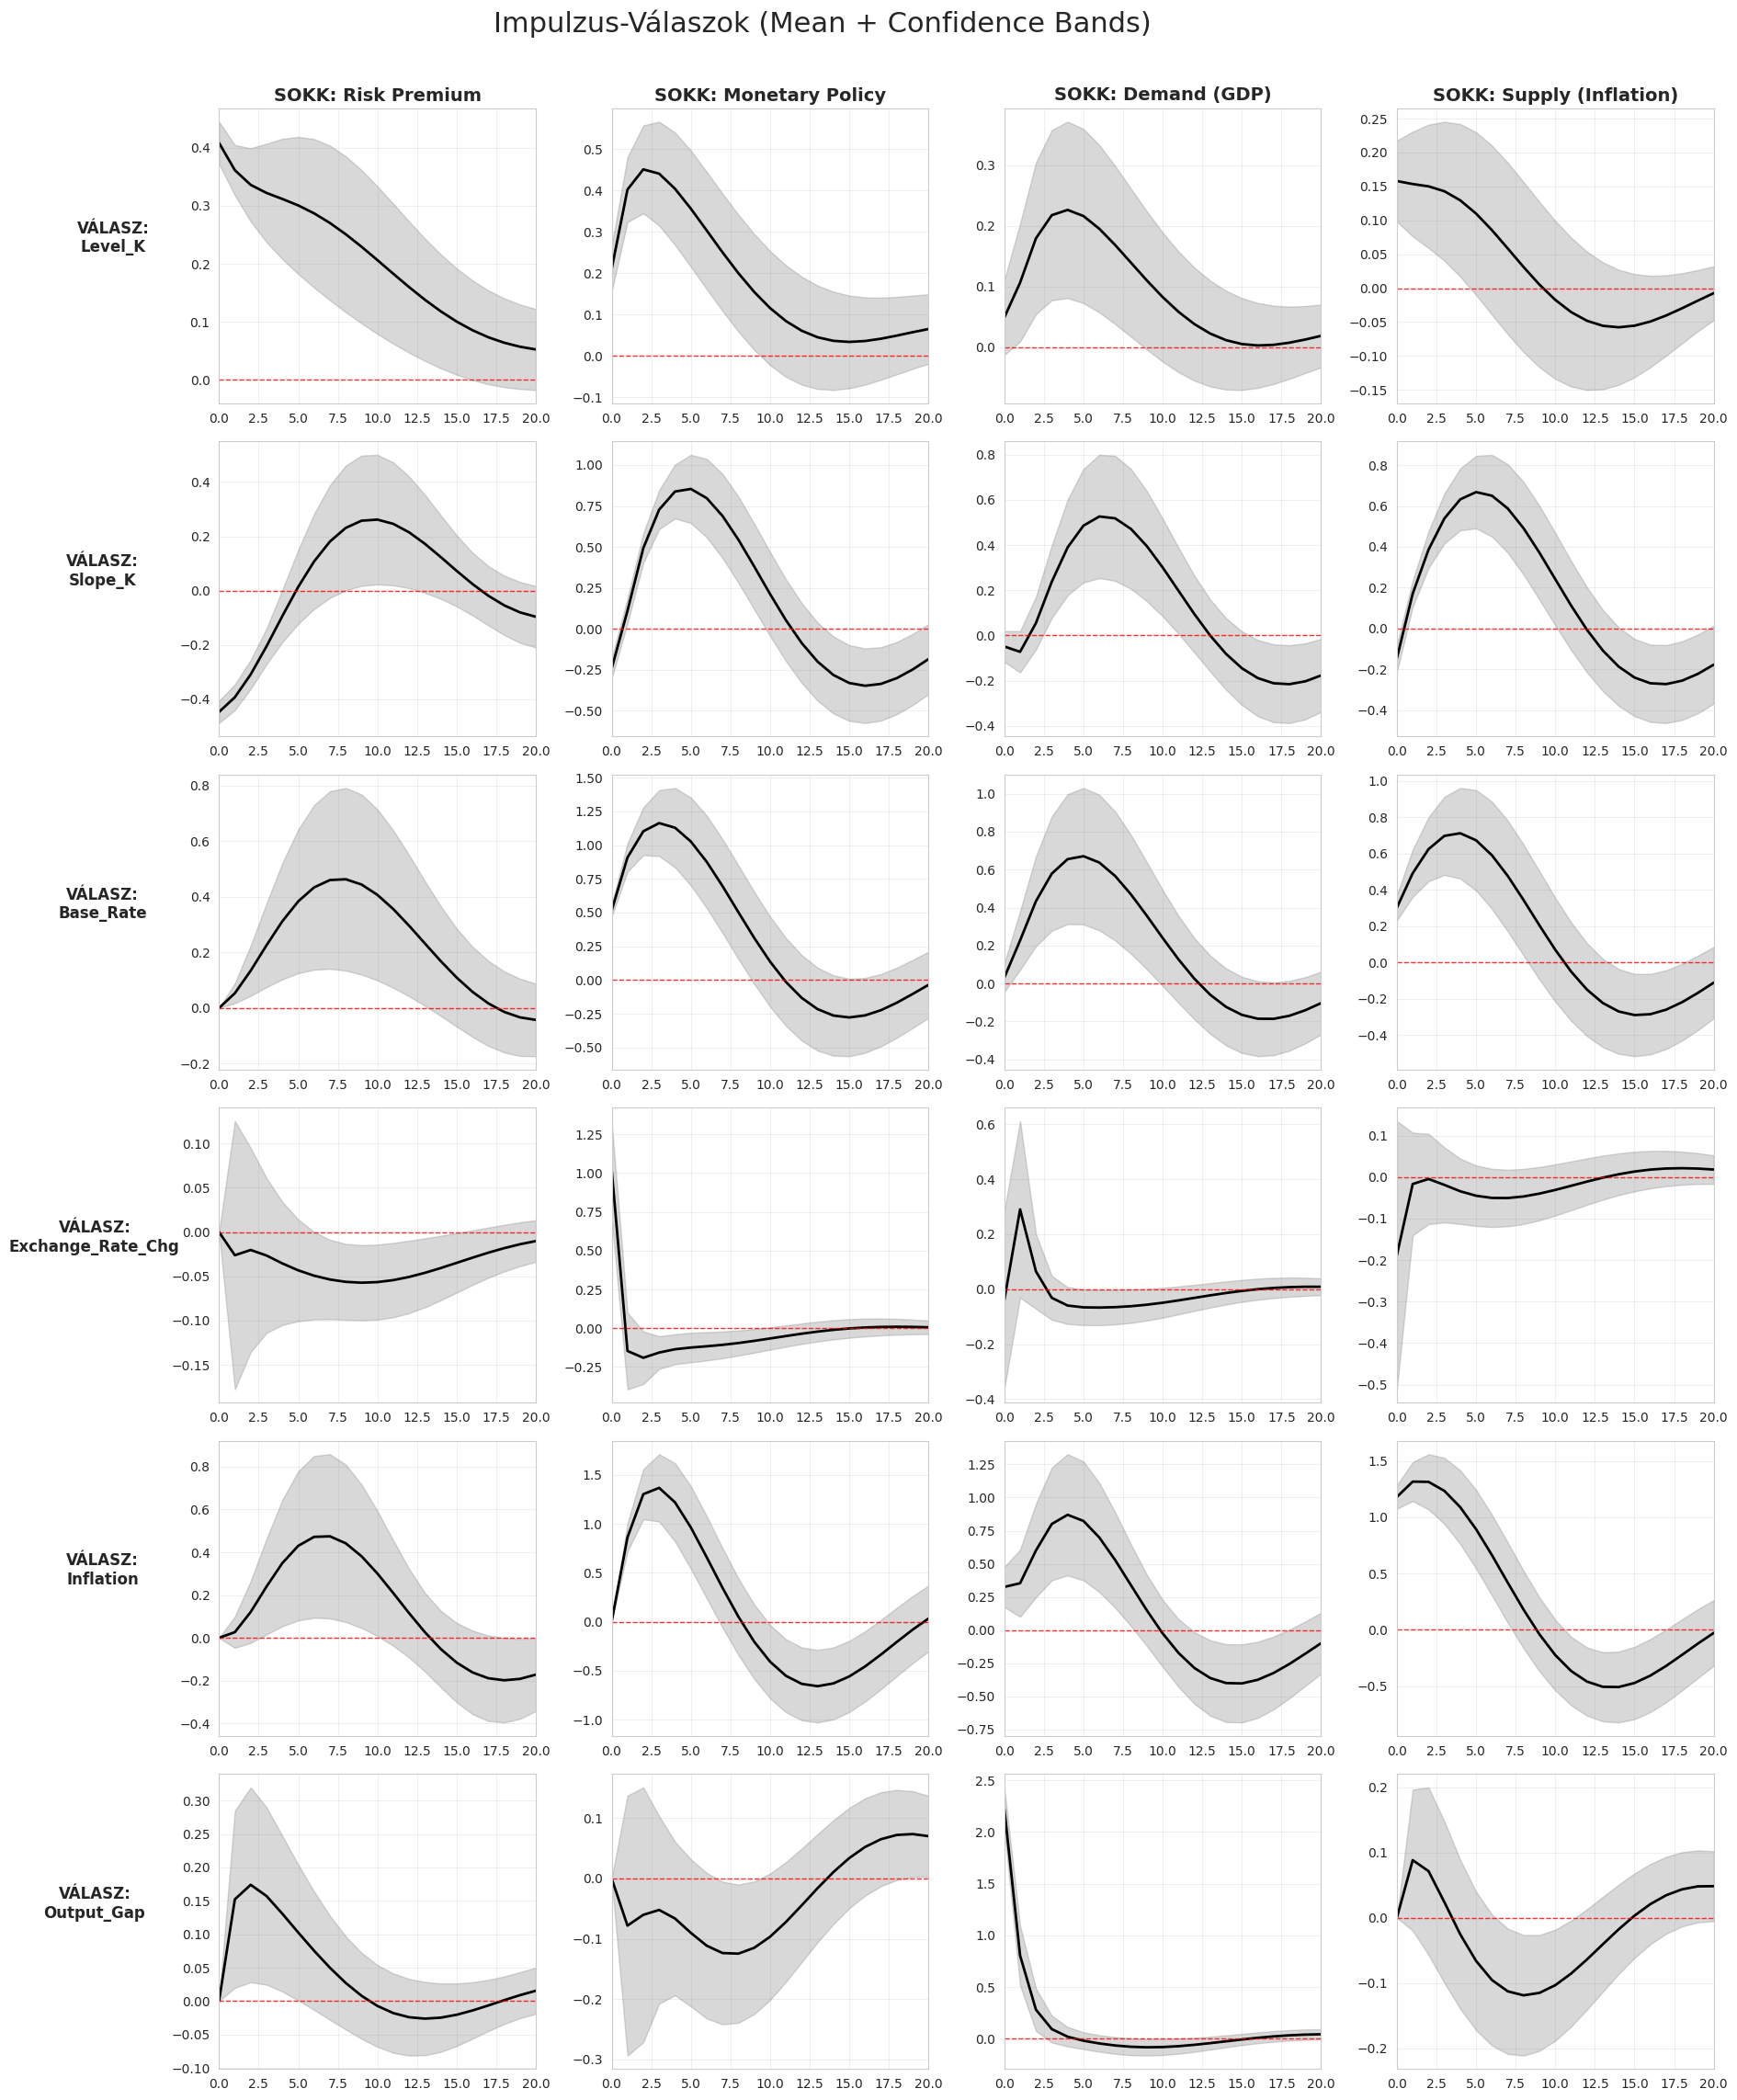

In [33]:
print("Impulzus-válaszok számítása és ábrázolása...")

# 1. IRF Számítása (Robusztus módszerrel)
periods = 20
irf_obj = results.irf(periods)

# Átlagos válasz (Ez általában stabil)
mean_irf = irf_obj.orth_irfs

# Hiba (Standard Error) számítása
# Megpróbáljuk az aszimptotikus módszert. Ha elhasal (NaN), akkor nullázzuk.
try:
    stderr_irf = irf_obj.stderr(orth=True)
    # Ha csupa NaN jön vissza (hiba), cseréljük nullára, hogy legalább a vonal látszódjon!
    if np.all(np.isnan(stderr_irf)):
        print("FIGYELEM: A standard hiba nem számítható (NaN). Csak az átlagot rajzoljuk.")
        stderr_irf = np.zeros_like(mean_irf)
    else:
        # A maradék NaN-okat is kiszedjük (biztos ami biztos)
        stderr_irf = np.nan_to_num(stderr_irf)
except:
    print("Hiba a szórás számításánál. Csak az átlagot rajzoljuk.")
    stderr_irf = np.zeros_like(mean_irf)

# 2. Változók megfeleltetése
# Ellenőrizzük, mi van a modellben
cols = var_data.columns.tolist()
shocks_map = {
    'Risk Premium':         'Level_K' if 'Level_K' in cols else ('Level_NS' if 'Level_NS' in cols else cols[-2]),
    'Monetary Policy':      'Base_Rate',
    'Demand (GDP)':         'Output_Gap',
    'Supply (Inflation)':   'Inflation'
}

# Sorrend (Válaszok)
response_vars = [v for v in ['Level_K', 'Slope_K', 'Level_NS', 'Slope_NS', 'Base_Rate', 'Exchange_Rate_Chg', 'Inflation', 'Output_Gap'] if v in cols]

# 3. Kirajzolás
fig, axes = plt.subplots(nrows=len(response_vars), ncols=4, figsize=(20, 4 * len(response_vars)))
fig.suptitle('Impulzus-Válaszok (Mean + Confidence Bands)', fontsize=22, y=0.95)

shock_names = list(shocks_map.keys())
shock_vars = list(shocks_map.values())

for row_idx, resp_var in enumerate(response_vars):
    for col_idx, shock_name in enumerate(shock_names):
        shock_var = shock_vars[col_idx]

        # Ha kevesebb a változó, mint a rács, kezeljük a hibát
        if row_idx >= len(axes): break
        ax = axes[row_idx, col_idx]

        try:
            impulse_idx = cols.index(shock_var)
            response_idx = cols.index(resp_var)

            # --- ADATOK ---
            # A statsmodels verziójától függően az indexelés lehet [idő, válasz, impulzus] vagy fordítva
            # A legbiztosabb: megnézzük az alakját
            if mean_irf.shape[0] == periods + 1:
                # Standard: (Idő, Válasz, Impulzus)
                series_mean = mean_irf[:, response_idx, impulse_idx]
                series_err = stderr_irf[:, response_idx, impulse_idx]
            else:
                # Fordított: (Válasz, Impulzus, Idő) - ritka, de előfordul
                series_mean = mean_irf[response_idx, impulse_idx, :]
                series_err = stderr_irf[response_idx, impulse_idx, :]

            # Konfidencia sávok (16-84%)
            upper = series_mean + series_err
            lower = series_mean - series_err

            # --- RAJZOLÁS ---
            # 1. Sáv (Ha van hiba)
            ax.fill_between(range(len(series_mean)), lower, upper, color='gray', alpha=0.3)

            # 2. Átlag (Fekete vonal) - Ennek most mindenképp látszódnia kell!
            ax.plot(series_mean, color='black', linewidth=2)

            # 3. Nulla vonal
            ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.8)

            # Címkék
            if row_idx == 0:
                ax.set_title(f"SOKK: {shock_name}", fontweight='bold', fontsize=14)
            if col_idx == 0:
                ax.set_ylabel(f"VÁLASZ:\n{resp_var}", fontweight='bold', rotation=0, labelpad=60, fontsize=12)

            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, periods)

        except Exception as e:
            ax.text(0.5, 0.5, "N/A", ha='center', va='center')
            print(f"Hiba a {shock_var}->{resp_var} plotnál: {e}")

plt.tight_layout(rect=[0.05, 0, 1, 0.94])
plt.show()

In [34]:
# A modell illesztése után (results = model.fit(1)) futtasd ezt:

# A reziduálisok kovariancia mátrixának kinyerése
sigma_u = results.sigma_u

# Cholesky-felbontás (a sokkok ortogonalizálásához)
import numpy as np
P = np.linalg.cholesky(sigma_u)

# A sokkok mérete a főátlóban található
shock_sizes = np.diag(P)

# Kiíratás érthető formában
print("Sokk méretek (1 szórásnyi impulzus):")
for i, var in enumerate(results.names):
    print(f"{var}: {shock_sizes[i]:.4f}")

Sokk méretek (1 szórásnyi impulzus):
Output_Gap: 2.2333
Inflation: 1.1792
Base_Rate: 0.5148
Exchange_Rate_Chg: 2.3459
Level_K: 0.4082
Slope_K: 0.0742
